In [97]:
from __future__ import division
from more_itertools import peekable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp
import pickle
import magenta
import os, time, re, json
%matplotlib inline
from IPython.core.display import display, HTML
### change width of notebook display
display(HTML("<style>.container { width:70% !important; }</style>"))

import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

# for exposing API
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from flask import Flask
from flask_restful import Resource, Api

JUPYTER_PICKLE_FILE = "config/shared_jupyter_data.pkl"
def write_shared_jupyter(key, value, path=JUPYTER_PICKLE_FILE, overwrite=False):
    if (os.path.exists(path)):
        with open(path, "rb") as fp:
            shared_jupyter_data = pickle.load(fp)
        if overwrite:
            shared_jupyter_data = {key: value}
        else:
            shared_jupyter_data[key] = value
    else:
        shared_jupyter_data = {key: value}
    with open(path, 'wb') as fp: 
        pickle.dump(shared_jupyter_data, fp)

def read_shared_jupyter(key=None, path=JUPYTER_PICKLE_FILE):
    if (os.path.exists(path)):
        with open(path, "rb") as fp:
            shared_jupyter_data = pickle.load(fp)
            if key is not None:
                if key in shared_jupyter_data:
                    return(shared_jupyter_data[key])
                else:
                    print("Not found!")
                    return(None)
            else:
                return(shared_jupyter_data)
    else:
        print("No data")

def pandasToJson(df):
    return(df.to_json(orient="split"))
def jsonToPandas(json):
    return(pd.read_json(json, orient="split"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

FIG_WIDTH = 1200
FIG_HEIGHT = 800

PITCH_MIN = 20
PITCH_MAX = 120
VELOCITY_MIN = 0
VELOCITY_MAX = 120

def hheader(x):
    print("#########################################")
    print("### {}".format(x))
    print("#########################################")

# Magenta dependencies:
# https://github.com/magenta/magenta

# Magenta uses pretty_midi to deal with midi files
import pretty_midi

# Read in music stream and make decisions

Each agent:
- Read in music stream
- Update predictive model
- Probabilistic decision rule: create order and submit

In [98]:
""" Each agent reads in music stream and responds
    (start with a single agent)
"""

""" Kalman filter parameters """

from scipy.stats import multivariate_normal
from statsmodels.tsa.stattools import acovf
from scipy.ndimage.interpolation import shift
np.random.seed(42)
np.set_printoptions(suppress=True) 

def pandas_fill(arr):
    df = pd.DataFrame(arr)
    df = df.fillna(method='ffill', axis=1, inplace=False)
    out = df.to_numpy()
    return out

# for now, keep the noise matrices as constants (can improve later)

# observations x: note, different dimension from Z (unlike sample code)
df_X = assetDataSoFar_df[['pitch_mean']]
x_obs = np.c_[df_X]
[n,d] = x_obs.shape

# create version of observations forward-filled
x_obs_nonna = x_obs.copy()
x_obs_nonna = pd.DataFrame(x_obs_nonna).ffill()[0].to_numpy().reshape(-1, 1)

# number of lags (minus one)
L = 14

### Latent state equation - vector z_t
# z_t = A_t z_{t-1} + <other regressors> + w_t
At = np.eye(L) # (L x L) - paper says to leave this as identity (random walk)
Qt = np.diag(np.ones(L)) # (L x L) covariance of errors in state eq. - TUNE THIS

### Observation equation - scalar x_t
# x_t = C_t z_t + <other regressors> + v_t
Ct = np.ones((1,L)) # (1 x L) - ARIMA lags - WILL OVERRIDE
Rt = np.diag(np.ones(1)) # (1 x 1)

# Simulate some plausible values for Qt and Rt
# (could make Rt self-updating if time)
Qt = np.diag(np.random.gamma(1,0.1,size=L)) # covar. mat is symmetric
Rt = np.random.gamma(3, 4, size=np.diag(np.ones(1)).shape)

# Initial conditions (for the state variable z, stored in mu vars)
# z0 = x_obs[1:(L+1)]
z0 = np.repeat(1/L, L).reshape(-1, 1) # make state variable the WEIGHTS on lags NOT the LAGS themselves
P0 = Qt

#Objects to store predictions and filtering locations
Z = np.zeros((n,L))
Zpred = np.zeros((n,L))
Xpred = np.zeros((n,L))

# store predictions
z = z0 # predicted zhat, ()
P = P0 # covariance of zhat, dim(L, L)
Ct0 = x_obs_nonna[0:(L)].T
# fill forward if NAs at the start (edge case)
if np.isnan(Ct).any():
    Ct0 = pandas_fill(Ct0)
Ct = Ct0

""" Iteration parameters """

from collections import OrderedDict
import requests

### Iteration parameters
STREAM_SLEEP_SEC = 1

""" Agent parameters """
WEALTH = 10000

""" Plotly parameters """
# keep it simple and update every iteration
DASH_PORT = 8122
PLOTLY_REFRESH_SEC = 0.5
PLOTLY_STREAM_SLEEP_SEC = PLOTLY_REFRESH_SEC * 5

# Iteration = whether to ping for more data
# extra level of sampling on top of the raw music stream (which itself is sampled)
iterations = 1
assetDataSoFar = OrderedDict()
initialModelTrained = False
while True:
    if (iterations % 5 == 1):
        print("Iteration {} ...".format(iterations + 1))
    
    ### Read in music stream (assume perpetual)
    currAssetData = requests.get("http://localhost:8100/read")
    if (currAssetData.status_code != 200):
        raise Exception("GET request failed.")
    currAsset = currAssetData.json()
    currAssetTime = currAsset['currTime']
    currAssetBar = jsonToPandas(currAsset['lastBar'])
    
    ### add to historical data if hasn't been seen yet
    for sx in range(currAssetBar.shape[0]):
        currAssetObs = currAssetBar.iloc[[sx]]
        currStreamingIx = currAssetObs.streaming_start_sec.values[0]
        if (currStreamingIx not in assetDataSoFar):
            assetDataSoFar[currStreamingIx] = currAssetObs
        else:
            print("Already stored")
    
    currAssetDataSoFar_df = pd.concat(assetDataSoFar.values())
    
    """
    Similar to market infrastructure plot, visualize all historical data seen so far
    Should be a sampling of the raw market infrastructure streaming.
    """
    server = Flask('my_app')
    external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
    app = JupyterDash(__name__, server=server, external_stylesheets=external_stylesheets)
    ### use later for sending trade signals
#     api = Api(server)
#     class vizStreamSoFar(Resource):
#         """ Get current snapshot of the music stream.
#             $ curl "http://localhost:8122/read"
#         """
#         def get(self):
#             return({"currTime": currTime, "lastBar": pandasToJson(lastBar)})
#     api.add_resource(vizStreamSoFar, '/read')
    app.layout = html.Div([
        html.H1("Agent sample statistics"),
        dcc.Graph(id='pitch_graph'),
        dcc.Interval(id='interval-component', interval=PLOTLY_REFRESH_SEC*1000, n_intervals=0)
    # ])
    ], style={'width': '80%', 'float': 'left', 'height': '4.5rem'})
    
    @app.callback(Output('pitch_graph', 'figure'), Input("interval-component", "n_intervals"))
    def update_pitch_figure(n=0):
        """
        Update plotly figure. (Like ggplot2: color based on group)
        currBar (global): variable with the current data.
        """
        fig = px.line(currAssetDataSoFar_df, x="streaming_start_sec",
                      y=['pitch_mean'],
                      render_mode="webgl", template="plotly_dark",
            title="Observed pitch statistics",range_y=[PITCH_MIN, PITCH_MAX]).update_traces(mode='markers+lines')
        return(fig)
    
    ### Run app locally (inline cuts off output)
    app.run_server(mode='external', port=DASH_PORT)
    
    """
    Wait until enough data so far before modeling work.
    need <<< refresh rate of streaming market infrastructure.
    """
    if (iterations < 3):
        time.sleep(STREAM_SLEEP_SEC)
        iterations += 1
        continue

    """ Analysis with current order here """
    
    ### get historical data so far 
    ### the current bar (currAssetBar) will be the last rows of this dataframe
    assetDataSoFar_df = pd.concat(assetDataSoFar.values())
    
    ### if model is not already trained, train model
    if not initialModelTrained:
        ### Initialize model
        raise Exception("Initialize model parameters etc.")
        
        ### Train predictive model on historical data so far (will take some time)
        
        initialModelTrained = True
    
    ### Update model on new data

    ### Take a short break between analyses (so plotly can catch up)
    ### should be >> plot auto-update interval so that all plots
    ### update basically at the same time. 
    time.sleep(STREAM_SLEEP_SEC) # 1 second is comfortable for nice UI
    iterations += 1

Iteration 2 ...
Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash app running on http://127.0.0.1:8

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash app running on http://127.0.0.1:8122/
Dash is running on http://127.0.0.1:8122/

Dash is run

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is run

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is run

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash app running on http://127.0.0.1:8122/
Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is running on http://127.0.0.1:8122/

Dash is run

KeyboardInterrupt: 

# offline analysis

In [3]:
assetDataSoFar_df = pd.concat(assetDataSoFar.values())
display(assetDataSoFar_df)
display(currAssetBar)

,streaming_start_sec,piece_num,start_sec,start_min,start_mean,start_median,start_max,start_str_concat,end_min,end_mean,end_median,end_max,end_str_concat,pitch_min,pitch_mean,pitch_median,pitch_max,pitch_str_concat,velocity_min,velocity_mean,velocity_median,velocity_max,velocity_str_concat,duration_min,duration_mean,duration_median,duration_max,duration_str_concat,canonical_composer_mode,split_mode,year_mode,total_duration_mode,curr_filename_mode,piece_changed
935,935,0,935,935.02812,935.491233,935.534895,935.89688,"935.02812,935.16875,935.18021,935.31042,935.33...",935.18229,935.665972,935.727085,936.07917,"935.18229,935.27083,935.31562,935.40312,935.68...",47.0,59.750000,53.0,79.0,"47,54,69,51,71,47,79,52,71,78,51,47",64.0,76.916667,76.0,89.0,"68,77,89,72,89,68,86,70,64,87,78,75",0.08542,0.174739,0.143750,0.35104,"0.15417,0.10208,0.13542,0.09271,0.35104,0.0854...",Johann Sebastian Bach,train,2004.0,967.16405,2004__MIDI-Unprocessed_SMF_02_R1_2004_01-05_OR...,0
936,936,0,936,936.03229,936.464098,936.425000,936.91250,"936.03229,936.05312,936.17396,936.17396,936.28...",936.10729,936.559583,936.497920,936.97292,"936.10729,936.13438,936.25208,936.25833,936.35...",47.0,65.933333,71.0,79.0,"69,54,71,51,54,75,57,78,47,79,75,71,55,76,77",51.0,79.600000,81.0,91.0,"83,75,86,71,80,88,76,90,88,91,87,76,81,71,51",0.03229,0.095485,0.075000,0.37604,"0.075,0.08125,0.07812,0.08438,0.07083,0.07083,...",Johann Sebastian Bach,train,2004.0,967.16405,2004__MIDI-Unprocessed_SMF_02_R1_2004_01-05_OR...,0
937,937,0,937,937.00208,937.457659,937.405210,937.97500,"937.00208,937.01354,937.12708,937.14271,937.15...",937.08229,937.560723,937.530210,938.06146,"937.10625,937.08229,937.18229,937.22396,937.20...",49.0,67.470588,73.0,81.0,"52,73,55,76,75,59,79,49,81,76,73,78,57,75,54,5...",51.0,79.588235,81.0,89.0,"76,86,77,81,51,77,89,89,88,87,80,79,83,85,71,7...",0.04167,0.103064,0.081250,0.49062,"0.10417,0.06875,0.05521,0.08125,0.04167,0.0510...",Johann Sebastian Bach,train,2004.0,967.16405,2004__MIDI-Unprocessed_SMF_02_R1_2004_01-05_OR...,0
938,938,0,938,938.10729,938.502149,938.506770,938.92188,"938.10729,938.11042,938.23646,938.23958,938.24...",938.15833,938.647916,938.625520,939.51042,"938.15833,938.24583,938.30417,938.61042,938.32...",47.0,68.062500,75.0,83.0,"60,81,51,83,78,75,59,57,78,83,55,76,52,79,47,75",26.0,77.687500,81.5,91.0,"77,85,91,72,86,84,79,81,79,26,88,82,73,74,82,84",0.03125,0.145768,0.076560,0.90000,"0.05104,0.13542,0.06771,0.37083,0.08021,0.0739...",Johann Sebastian Bach,train,2004.0,967.16405,2004__MIDI-Unprocessed_SMF_02_R1_2004_01-05_OR...,0
939,939,0,939,939.06146,939.401232,939.331250,939.89271,"939.06146,939.07188,939.19375,939.20521,939.31...",939.15938,939.540624,939.401040,940.04896,"939.20208,939.15938,939.23854,939.31562,939.37...",43.0,66.727273,76.0,81.0,"52,76,47,79,43,75,48,76,80,81,77",77.0,84.181818,82.0,95.0,"92,83,81,78,90,87,95,82,77,82,79",0.04479,0.139393,0.087500,0.55729,"0.14062,0.0875,0.04479,0.11042,0.05104,0.06979...",Johann Sebastian Bach,train,2004.0,967.16405,2004__MIDI-Unprocessed_SMF_02_R1_2004_01-05_OR...,0
945,945,1,1,1.96563,1.976303,1.972395,1.99479,"1.96563,1.96667,1.97812,1.99479",3.73229,3.823437,3.818750,3.92396,"3.73229,3.89062,3.74688,3.92396",48.0,54.750000,54.5,62.0,"53,62,56,48",45.0,59.000000,60.5,70.0,"55,70,66,45",1.76667,1.847138,1.846355,1.92917,"1.76667,1.92396,1.76875,1.92917",Sergei Rachmaninoff,validation,2004.0,266.40602,2004__MIDI-Unprocessed_SMF_02_R1_2004_01-05_OR...,0
946,946,1,2,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,None,0
947,947,1,3,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,None,0
948,948,1,4,4.36979,4.536922,4.646870,4.66875,"4.36979,4.37188,4.38333,4.39167,4.64687,4.6666...",4.44479,4.863772,4.992710,5.18646,"4.56354,4.63854,4.44479,4.61562,5.15312,4.9927...",39.0,54.333333,55.0,67.0,"54,63,59,44,60,39,67,48,55",3

,streaming_start_sec,piece_num,start_sec,start_min,start_mean,start_median,start_max,start_str_concat,end_min,end_mean,end_median,end_max,end_str_concat,pitch_min,pitch_mean,pitch_median,pitch_max,pitch_str_concat,velocity_min,velocity_mean,velocity_median,velocity_max,velocity_str_concat,duration_min,duration_mean,duration_median,duration_max,duration_str_concat,canonical_composer_mode,split_mode,year_mode,total_duration_mode,curr_filename_mode,piece_changed
1225,1225,2,59,59.09688,59.526711,59.584895,59.92604,"59.09688,59.09688,59.12188,59.32708,59.36875,5...",59.15833,59.720311,59.800000,60.10104,"59.31562,59.16771,59.15833,59.95417,59.59271,5...",48,66.571429,69.0,77,"55,77,67,60,76,69,70,52,74,76,69,48,67,72",53,67.357143,69.5,78,"74,75,53,73,76,61,63,59,68,73,59,60,71,78",0.03646,0.193601,0.165105,0.62708,"0.21875,0.07083,0.03646,0.62708,0.22396,0.1135...",Sergei Rachmaninoff,test,2004,189.82908,2004__MIDI-Unprocessed_SMF_02_R1_2004_01-05_OR...,0
1226,1226,2,60,60.07083,60.474358,60.436460,60.82917,"60.07083,60.07188,60.22604,60.23125,60.41458,6...",60.14792,60.630288,60.569790,61.07500,"60.22812,60.14792,60.44688,60.40417,60.56979,6...",43,63.153846,64.0,74,"74,65,70,64,72,62,58,48,69,64,43,70,62",41,62.384615,64.0,76,"76,70,72,67,71,64,41,55,61,49,58,70,57",0.05417,0.155929,0.157290,0.26146,"0.15729,0.07604,0.22083,0.17292,0.15521,0.125,...",Sergei Rachmaninoff,test,2004,189.82908,2004__MIDI-Unprocessed_SMF_02_R1_2004_01-05_OR...,0
1227,1227,2,61,61.07188,61.528056,61.559380,61.88750,"61.07188,61.14375,61.15833,61.16042,61.41042,6...",61.21458,61.633262,61.612500,62.17083,"61.25729,61.21458,61.25833,61.21458,61.44792,6...",36,57.933333,60.0,67,"36,64,67,60,60,55,43,60,62,64,52,60,64,67,55",11,52.466667,56.0,71,"53,65,61,56,34,37,61,55,57,56,56,11,59,71,55",0.03333,0.105208,0.054170,0.63125,"0.18542,0.07083,0.1,0.05417,0.0375,0.04583,0.6...",Sergei Rachmaninoff,test,2004,189.82908,2004__MIDI-Unprocessed_SMF_02_R1_2004_01-05_OR...,0
1228,1228,2,62,62.03125,62.452691,62.360415,62.93646,"62.03125,62.03542,62.07917,62.25,62.27188,62.2...",62.09583,62.593663,62.729165,62.98542,"62.24375,62.09583,62.11875,62.29167,62.72708,6...",52,64.666667,65.5,74,"52,72,67,55,74,72,60,62,64,67,64,67",24,59.750000,61.5,77,"55,77,24,48,76,69,68,60,55,65,63,57",0.03646,0.140973,0.056250,0.45729,"0.2125,0.06042,0.03958,0.04167,0.45521,0.45729...",Sergei Rachmaninoff,test,2004,189.82908,2004__MIDI-Unprocessed_SMF_02_R1_2004_01-05_OR...,0
1229,1229,2,63,63.10104,63.460863,63.444790,63.93542,"63.10104,63.10208,63.10417,63.24688,63.25729,6...",63.13542,63.620683,63.576040,64.31979,"63.17187,63.74375,63.13542,63.28125,63.40312,6...",55,71.357143,72.0,84,"72,55,67,74,64,76,72,74,79,64,67,84,79,72",10,65.357143,69.0,85,"69,60,67,76,69,84,52,10,85,64,57,80,73,69",0.02604,0.159821,0.069790,0.64167,"0.07083,0.64167,0.03125,0.03437,0.14583,0.0572...",Sergei Rachmaninoff,test,2004,189.82908,2004__MIDI-Unprocessed_SMF_02_R1_2004_01-05_OR...,0


<AxesSubplot:xlabel='streaming_start_sec', ylabel='pitch_mean'>

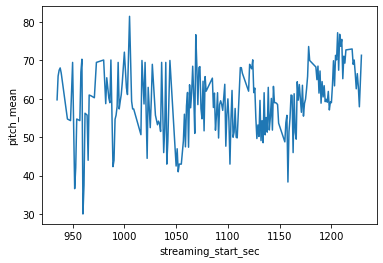

In [4]:
"""
plot time series of interest
"""
import seaborn as sns
sns.lineplot(data=assetDataSoFar_df, x="streaming_start_sec", y="pitch_mean")

In [61]:
"""
OFFLINE NEED TO MOVE ONLINE

Find structural breaks: Kalman filter + CUSUM or some other online test
Inspo: file:///C:/Users/echow/AppData/Local/Temp/remotesensing-12-03135-v2.pdf
"""
from scipy.stats import multivariate_normal
from statsmodels.tsa.stattools import acovf
from scipy.ndimage.interpolation import shift
np.random.seed(42)

np.set_printoptions(suppress=True) 

def pandas_fill(arr):
    df = pd.DataFrame(arr)
    df = df.fillna(method='ffill', axis=1, inplace=False)
    out = df.to_numpy()
    return out

# for now, keep the noise matrices as constants (can improve later)

# observations x: note, different dimension from Z (unlike sample code)
df_X = assetDataSoFar_df[['pitch_mean']]
x_obs = np.c_[df_X]
[n,d] = x_obs.shape

# create version of observations forward-filled
x_obs_nonna = x_obs.copy()
x_obs_nonna = pd.DataFrame(x_obs_nonna).ffill()[0].to_numpy().reshape(-1, 1)

# number of lags (minus one)
L = 14

### Latent state equation - vector z_t
# z_t = A_t z_{t-1} + <other regressors> + w_t
At = np.eye(L) # (L x L) - paper says to leave this as identity (random walk)
Qt = np.diag(np.ones(L)) # (L x L) covariance of errors in state eq. - TUNE THIS

### Observation equation - scalar x_t
# x_t = C_t z_t + <other regressors> + v_t
Ct = np.ones((1,L)) # (1 x L) - ARIMA lags - WILL OVERRIDE
Rt = np.diag(np.ones(1)) # (1 x 1)

# df_x_obs_nonna_lags = []
# for l in range(0, L):
#     curr = shift(x_obs_nonna.reshape(-1,), l, cval=np.nan)
#     df_curr = pd.DataFrame(curr, columns=["l{}".format(l)])
#     df_x_obs_nonna_lags.append(df_curr)
# df_x_obs_nonna_lags = pd.concat(df_x_obs_nonna_lags, axis=1).dropna()
# cov_mat_lags = df_x_obs_nonna_lags.cov()

# # Tune Qt with historical covariances
# Qt = cov_mat_lags

# Simulate some plausible values for Qt and Rt
# (could make Rt self-updating if time)
Qt = np.diag(np.random.gamma(1,0.1,size=L)) # needs to be symmetric to be a proper covariance matrix
Rt = np.random.gamma(3, 4, size=np.diag(np.ones(1)).shape)
# At, Qt, Ct, Rt

In [70]:
# Initial conditions (for the state variable z, stored in mu vars)
# z0 = x_obs[1:(L+1)]
z0 = np.repeat(1/L, L).reshape(-1, 1) # make state variable the WEIGHTS on lags NOT the LAGS themselves
P0 = Qt

#Objects to store predictions and filtering locations
Z = np.zeros((n,L))
Zpred = np.zeros((n,L))
Xpred = np.zeros((n,L))

# store predictions
z = z0 # predicted zhat, ()
P = P0 # covariance of zhat, dim(L, L)
Ct0 = x_obs_nonna[0:(L)].T
# fill forward if NAs at the start (edge case)
if np.isnan(Ct).any():
    Ct0 = pandas_fill(Ct0)
Ct = Ct0

timerange = range(L, n-1) # data starts at 0 so start analysis at L for L lags
for i in timerange:
        
    ### Get current observations xt, t
    # if missing value NA (resulting in missing Kalman predictions) then
    # just run the prediction step and continue
    # https://stats.stackexchange.com/questions/140990/using-kalman-filters-to-impute-missing-values-in-time-series
    x = np.array(x_obs[i])
    missing = any(np.isnan(x))
    
    ### Prediction step using previous data against new data ---------------------------------------
    ### (can update variables directly bc don't require t-1|t-1 thereafter)
    # zhat, t|t-1
    z = At.dot(z)
    # Phat, t|t-1
    P = At.dot(P).dot(At.T) + Qt
    Zpred[i,:] = z.T
    xhat = Ct.dot(z)
    Xpred[i,:] = xhat
    
    if not missing:
        print("Predicted: {:5f}. Actual: {:5f}. (Error: {:5f})".format(float(x), float(xhat), float(x - xhat)))
    else:
        print("... NaN value in x data, this is normal. Continue.")
    
    ### Implement CUSUM for change point detection - later
    ### (use low p-value and update every time)
    
    ### Measurement update incorporating new data ---------------------------------------------------
    
    # handle missing
    if (missing):
        Z[i,:] = np.nan
        continue
    
    ### embed ARIMA within the Kalman filter
    Ct = x_obs_nonna[(i-L):(i)].T

    ### Calculate Kalman gain and update log-likehoo
    # Kalman gain Kt
    S = Ct.dot(P).dot(Ct.T) + Rt
    Kt = P.dot(Ct.T).dot( np.linalg.inv(S))
    # update log-likelihood
    
    ### Measurement update step
    # update zhat, t
    # this Ct dot Z is just way too big, i.e. doesn't estimate x well.
    # So 
    z = z + Kt.dot(x - Ct.dot(z))
    Z[i,:] = z.T
    # update P, t|t
    P = P - Kt.dot(Ct).dot(P)

Predicted: 58.750000. Actual: 58.053571. (Error: 0.696429)
Predicted: 56.750000. Actual: 58.749514. (Error: -1.999514)
Predicted: 57.500000. Actual: 56.753091. (Error: 0.746909)
Predicted: 58.000000. Actual: 57.498365. (Error: 0.501635)
Predicted: 57.200000. Actual: 57.998662. (Error: -0.798662)
Predicted: 61.666667. Actual: 57.201141. (Error: 4.465526)
Predicted: 61.400000. Actual: 61.660942. (Error: -0.260942)
Predicted: 60.000000. Actual: 61.401472. (Error: -1.401472)
Predicted: 59.000000. Actual: 60.002581. (Error: -1.002581)
Predicted: 53.666667. Actual: 59.001497. (Error: -5.334830)
Predicted: 63.750000. Actual: 53.674208. (Error: 10.075792)
Predicted: 55.000000. Actual: 63.735360. (Error: -8.735360)
Predicted: 60.000000. Actual: 55.012661. (Error: 4.987339)
Predicted: 56.750000. Actual: 59.993615. (Error: -3.243615)
Predicted: 55.250000. Actual: 56.753100. (Error: -1.503100)
Predicted: 57.571429. Actual: 55.252435. (Error: 2.318994)
Predicted: 59.666667. Actual: 57.567598. (Erro

In [96]:
### Plot predictions
t=timerange # start from when have enough lags
# t=range(0, n-1) # plot full time range

df_plt = pd.DataFrame({
    "time": t,
    "raw": x_obs[t, 0],
    "pred": Xpred[t, 0]
#     "predicted": Zpred[timerange,0],
#     "filtered": Z[timerange, 0]
})
df_plt.head()
fig1 = px.line(df_plt, x="time", y=["raw", "pred"], template="plotly_dark")

### Plot prediction errors
df_plt = pd.DataFrame({
    "time": t,
    "error": (x_obs[t, 0] - Xpred[t, 0]),
    "error_sqr": (x_obs[t,0] - Xpred[t, 0])**2
})
df_plt.head()
fig2 = px.line(df_plt, x="time", y=["error"], template="plotly_dark")

### Plot Kalman-estimated coefficient paths (coefs on lags)
df_coefs = pd.DataFrame(Zpred)
df_coefs.columns = ["l{}".format(l) for l in range(df_coefs.shape[1])]
df_coefs = df_coefs.reset_index()

fig3 = px.line(df_coefs, x="index",
               y=[c for c in df_coefs.columns if c != "index"], template="plotly_dark")

print("Error stats for {} lags: ")
print("MSE: {}\n\n".format(df_plt[['error_sqr']].mean()))
print(df_plt[['error']].describe())
display(fig1)
display(fig2)
display(fig3)

Error stats for {} lags: 
MSE: error_sqr    17.021681
dtype: float64


           error
count  90.000000
mean    0.124430
std     4.146960
min   -11.258683
25%    -1.606179
50%     0.000287
75%     1.699760
max    15.748464


In [ ]:
"""
start with one single time series - e.g. trading pitch_mean
build Bayesian forecasting model based on that pitch_mean
build trading rules on top of that, e.g. if think will go up with high confidence or rather rapidly, then submit buy signal
"""